# Step 1 — Adding Salt & Pepper Noise to the Image (amount = 0.05)

In this step, we load the `Lena.png` image, convert it to grayscale, and add 5% Salt & Pepper noise.  
Salt & Pepper noise randomly turns some pixels into either 0 (pepper) or 255 (salt), simulating impulsive noise.

We also visualize both the original and the noisy image.  
Replicate padding will be required later when implementing the min, max, and median filters manually.


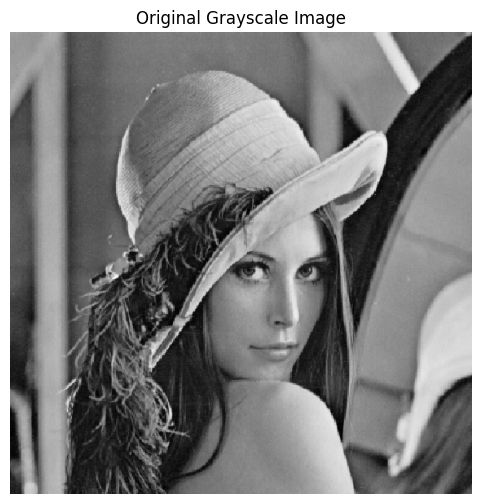

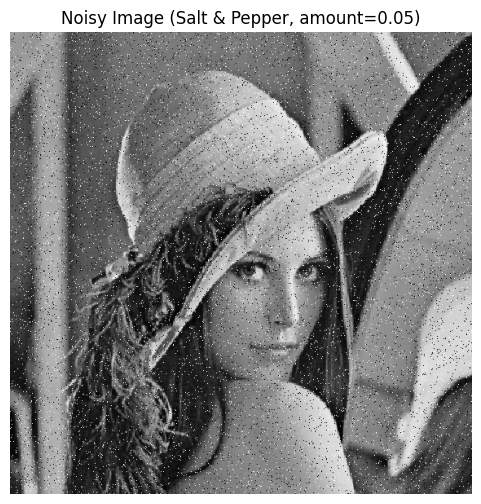

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def add_salt_pepper(image, amount=0.05, salt_vs_pepper=0.5, seed=None):
    """
    Add salt & pepper noise to a grayscale image.
    image: 2D numpy array dtype uint8 or float (0-255)
    amount: fraction of pixels to alter (e.g., 0.05)
    salt_vs_pepper: fraction of noisy pixels that are salt (1=all salt, 0=all pepper)
    seed: optional random seed for reproducibility
    Returns a noisy copy (same dtype as input)
    """
    if seed is not None:
        np.random.seed(seed)
    
    out = image.copy()
    H, W = out.shape
    num_total = H * W
    num_noisy = int(amount * num_total)
    
    # Number of salt vs pepper pixels
    num_salt = int(np.round(num_noisy * salt_vs_pepper))
    num_pepper = num_noisy - num_salt

    # Generate random coordinates for salt
    coords_salt = (
        np.random.randint(0, H, size=num_salt),
        np.random.randint(0, W, size=num_salt)
    )
    out[coords_salt] = 255

    # Generate random coordinates for pepper
    coords_pepper = (
        np.random.randint(0, H, size=num_pepper),
        np.random.randint(0, W, size=num_pepper)
    )
    out[coords_pepper] = 0

    return out

def replicate_pad(image, pad=1):
    """
    Replicate padding for a 2D image.
    image: 2D numpy array
    pad: padding width (int)
    Returns padded image
    """
    H, W = image.shape
    out = np.zeros((H + 2*pad, W + 2*pad), dtype=image.dtype)
    # center
    out[pad:pad+H, pad:pad+W] = image
    # top and bottom
    out[:pad, pad:pad+W] = image[0:1, :]
    out[pad+H:, pad:pad+W] = image[-1:, :]
    # left and right
    out[:, :pad] = out[:, pad:pad+1]
    out[:, pad+W:] = out[:, pad+W-1:pad+W]
    return out

# -------------------------
# Load Lena.png and prepare
img_path = "Lena.png"   # adjust path if needed
img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
if img is None:
    raise FileNotFoundError(f"Cannot find {img_path} in working directory")

# Convert to grayscale if needed
if img.ndim == 3:
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
else:
    img_gray = img.copy()

# Ensure uint8
if img_gray.dtype != np.uint8:
    img_gray = img_gray.astype(np.uint8)

# Show original
plt.figure(figsize=(6,6))
plt.imshow(img_gray, cmap='gray', vmin=0, vmax=255)
plt.title("Original Grayscale Image")
plt.axis('off')
plt.show()

# Add salt & pepper noise
amount = 0.05
noisy_img = add_salt_pepper(img_gray, amount=amount, salt_vs_pepper=0.5, seed=42)

plt.figure(figsize=(6,6))
plt.imshow(noisy_img, cmap='gray', vmin=0, vmax=255)
plt.title(f"Noisy Image (Salt & Pepper, amount={amount})")
plt.axis('off')
plt.show()


# Step 2 — Replicate Padding

Before applying min, max, and median filters manually, we must pad the image.
Since each filter uses a 3×3 window, without padding the pixels on the borders
would not have enough neighbors.

We use *replicate padding*, which means:
- The border pixels are copied outward.
- This avoids introducing artificial dark or bright borders.
- It is commonly used in filtering operations to preserve the structure at the edges.

In this step, we implement our own replicate padding function without using libraries.


# Displaying the Padded Image

This step visualizes the padded image created with replicate padding.
The padding extends the borders by copying edge values outward.
The padded image should look almost identical to the original noisy image,
but with a 1-pixel border that repeats the edge pixels.


Original shape: (567, 567)
Padded shape: (569, 569)


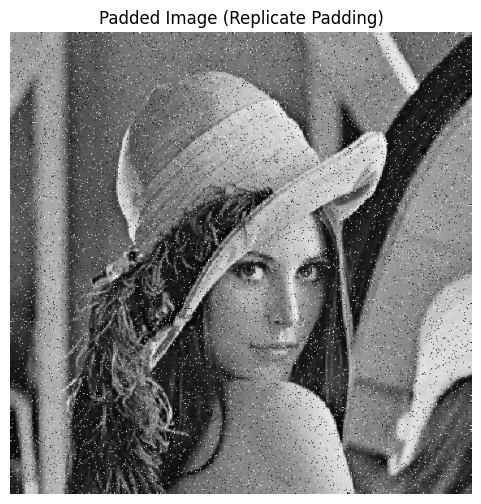

Top-left padded corner: 159
Original top-left: 159
Top padded row sample: 173 171
Left padded col sample: 161 159


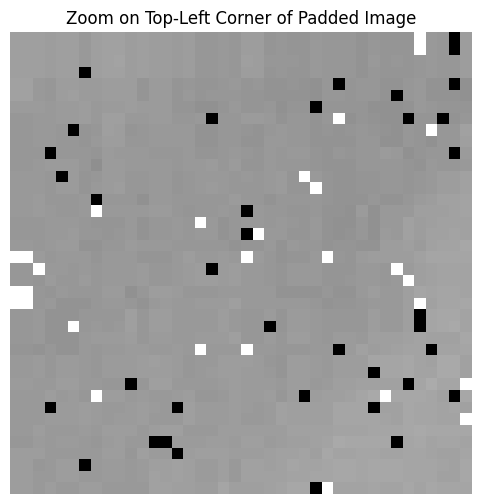

In [8]:
import numpy as np
import matplotlib.pyplot as plt


def replicate_padding(image):
    H, W = image.shape
    padded = np.zeros((H + 2, W + 2), dtype=image.dtype)

    # Copy center
    padded[1:H+1, 1:W+1] = image

    # Replicate top and bottom rows
    padded[0, 1:W+1] = image[0, :]
    padded[H+1, 1:W+1] = image[H-1, :]

    # Replicate left and right columns
    padded[1:H+1, 0] = image[:, 0]
    padded[1:H+1, W+1] = image[:, W-1]

    # Replicate corners
    padded[0, 0] = image[0, 0]
    padded[0, W+1] = image[0, W-1]
    padded[H+1, 0] = image[H-1, 0]
    padded[H+1, W+1] = image[H-1, W-1]

    return padded

# Apply padding
padded_img = replicate_padding(noisy_img)

print("Original shape:", noisy_img.shape)
print("Padded shape:", padded_img.shape)


plt.figure(figsize=(6,6))
plt.imshow(padded_img, cmap='gray')
plt.title("Padded Image (Replicate Padding)")
plt.axis('off')
plt.show()


print("Top-left padded corner:", padded_img[0,0])
print("Original top-left:", noisy_img[0,0])

print("Top padded row sample:", padded_img[0, 50], noisy_img[0, 50])
print("Left padded col sample:", padded_img[50, 0], noisy_img[50, 0])

plt.figure(figsize=(6,6))
plt.imshow(padded_img[0:40, 0:40], cmap='gray')
plt.title("Zoom on Top-Left Corner of Padded Image")
plt.axis('off')
plt.show()


# Step 3 — Min Filter (Manual Implementation)

We now apply a 3×3 Min Filter to the padded image.

A Min Filter replaces each pixel with the minimum value inside its 3×3 neighborhood.
This filter is useful for removing "white" noise pixels (Salt = 255), because
the minimum operation pushes the intensity downward.

However, it may also darken the image and erode bright regions.


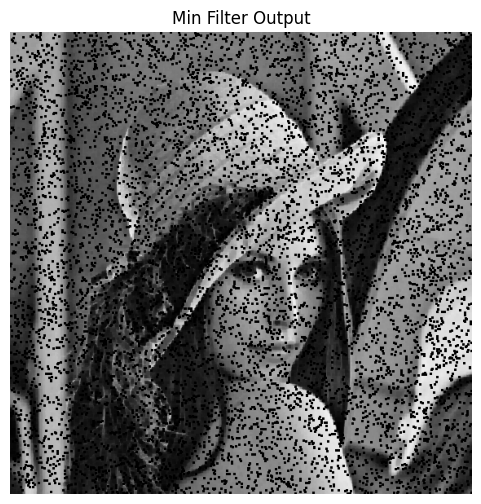

In [9]:
def min_filter(padded):
    H, W = padded.shape
    out = np.zeros((H-2, W-2), dtype=padded.dtype)

    for i in range(1, H-1):
        for j in range(1, W-1):
            window = padded[i-1:i+2, j-1:j+2]
            out[i-1, j-1] = np.min(window)

    return out

min_img = min_filter(padded_img)

plt.figure(figsize=(6,6))
plt.imshow(min_img, cmap='gray')
plt.title("Min Filter Output")
plt.axis('off')
plt.show()


# Step 3 — Max Filter (Manual Implementation)

The Max Filter replaces each pixel with the maximum value inside its 3×3 neighborhood.
This filter is good for removing "pepper" noise (black pixels = 0), because the
maximum operation pushes intensities upward.

However, it tends to brighten the image and may erode dark regions.


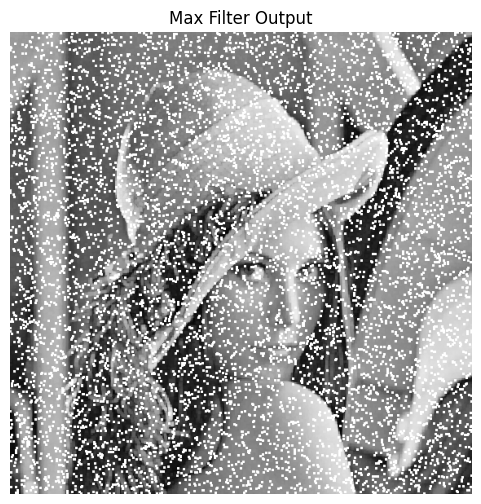

In [11]:
def max_filter(padded):
    H, W = padded.shape
    out = np.zeros((H-2, W-2), dtype=padded.dtype)

    for i in range(1, H-1):
        for j in range(1, W-1):
            window = padded[i-1:i+2, j-1:j+2]
            out[i-1, j-1] = np.max(window)

    return out

max_img = max_filter(padded_img)

plt.figure(figsize=(6,6))
plt.imshow(max_img, cmap='gray')
plt.title("Max Filter Output")
plt.axis('off')
plt.show()


# Step 3 — Median Filter (Manual Implementation)

The Median Filter replaces each pixel with the median value inside its 3×3 window.
It is the most effective filter for Salt & Pepper noise because:

• Salt noise (255) is pushed toward the middle of sorted values.
• Pepper noise (0) is also pushed upward.
• The median keeps the central trend of the neighborhood.
• Unlike min or max filters, it does NOT distort edges significantly.

This makes the median filter the standard method for removing impulsive noise.


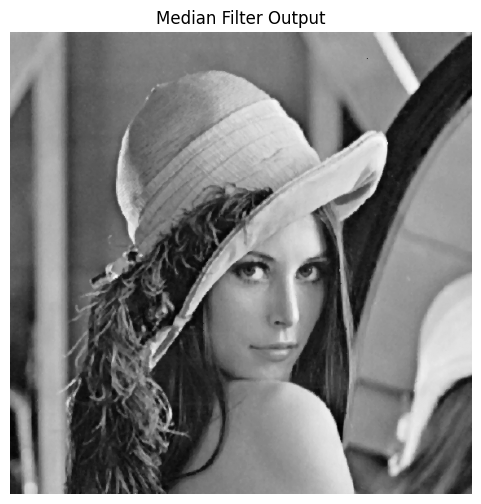

In [12]:
def median_filter(padded):
    H, W = padded.shape
    out = np.zeros((H-2, W-2), dtype=padded.dtype)

    for i in range(1, H-1):
        for j in range(1, W-1):
            window = padded[i-1:i+2, j-1:j+2].flatten()
            out[i-1, j-1] = np.median(window)

    return out


median_img = median_filter(padded_img)

plt.figure(figsize=(6,6))
plt.imshow(median_img, cmap='gray')
plt.title("Median Filter Output")
plt.axis('off')
plt.show()
